In [2]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [3]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool  = TavilySearchResults(max_results=2)
tools = [tool]

In [4]:
tool.invoke("Langgraphのノードとは？")

[{'title': 'LangGraphとは？エージェントの使い方とワークフロー構築法を ...',
  'url': 'https://weel.co.jp/media/tech/langgraph/',
  'content': '参考：https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/visualization.ipynb\nLangGraphを使うことにより複数のエージェントを定義することができ、それぞれに特定の役割を持たせることができます。また、各ステップを「ノード」として定義して「状態の遷移」を制御可能。さらに、条件付き遷移や処理の再実行が簡単にできるなどのメリットがあります。\nLangGraphはRAGのような使い方もできますが、LangGraphとRAGは異なっており、RAGはLLMに不足している知識を外部データベースから補完するのに対して、LangGraphはその処理の流れ(検索→生成→出力など)をノードとして組み、順序や条件を制御する役割を担っています。\nLangGraphの構成要素\nLangGraphにはノードや状態の遷移以外にも構成要素があります。※1\n先ほどの画像と見比べながら解説をします。',
  'score': 0.8687491},
 {'title': 'LangGraphの基本的な使い方',
  'url': 'https://zenn.dev/pharmax/articles/8796b892eed183',
  'content': 'コンポーネント | 説明\nGraph | LangGraphの中核となる構成要素で、各NodeとEdgeの集合体です。\nState | ノード間の遷移の際に保持される情報で、各ノードが参照および更新します。\nNode | グラフ内の個々のステップや状態を表す要素で、特定のアクションやチェックポイントとして機能します。\nEdge | ノード間の接続を表し、遷移の条件やアクションを定義します。条件付きエッジなど、特定のロジックに基づいて遷移を制御できます。\nGraph\n\nGraphは、LangGraphの中核となるグラフ全体を管理するためのコンポーネントです。基本的な使い方としては、S

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

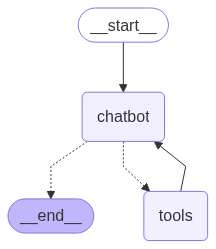

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [user_input]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！何かお手伝いできることはありますか？
1足す2は？
1足す2は3です。何か他に計算したいことがあれば教えてください！
1メートル以上の魚は？

[{"title": "クエ（海からの贈りもの） - 和歌山県 日高町", "url": "http://cms.town.wakayama-hidaka.lg.jp/docs/2014090300054/", "content": "少々いかつい顔をしたこの“どでかい魚”、名前はクエ。 大きいものでは、体長1メートル以上にも達する大型魚です。関東以南の太平洋沿岸から東シナ海沿岸にかけての温かい海", "score": 0.78473216}, {"title": "オオニベ | 魚類 - 市場魚貝類図鑑 ぼうずコンニャク", "url": "https://www.zukan-bouz.com/syu/%E3%82%AA%E3%82%AA%E3%83%8B%E3%83%99", "content": "1m以上になる大型魚でイヤミのない魚なので知名度はないものの、徐々に人気を得ている。 関東の市場でも普通になっていて、切り身などで小売店に並ぶこともある", "score": 0.76847315}]
1メートル以上の魚には以下のような種類があります：

1. **クエ**  
   [和歌山県日高町の情報](http://cms.town.wakayama-hidaka.lg.jp/docs/2014090300054/)によると、クエは体長1メートル以上にも達する大型魚で、関東以南の太平洋沿岸から東シナ海沿岸にかけて生息しています。

2. **オオニベ**  
   [市場魚貝類図鑑](https://www.zukan-bouz.com/syu/%E3%82%AA%E3%82%AA%E3%83%8B%E3%83%99)によると、オオニベも1メートル以上になる大型魚で、知名度はあまり高くないものの、徐々に人気を得ている魚です。

他にも知りたい魚の種類があれば教えてください！
ありがとうございました!
